## Importing packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import math
from collections import Counter


## Importing data

In [2]:
def func_import_100_sample(events_called):
    hits = []
    cells = []
    particles = []
    truth = []
    for i in range(0,events_called):# append datasets into the list
        if i < 10:
            temp_df = pd.read_csv('train_100_events/event00000100%d-hits.csv' % i)
            #c_c = pd.read_csv('train_100_events/event00000100%d-cells.csv'% i )
            p_c = pd.read_csv('train_100_events/event00000100%d-particles.csv'% i)
            t_c = pd.read_csv('train_100_events/event00000100%d-truth.csv'% i)
            hits.append(temp_df)
            #cells.append(c_c)
            particles.append(p_c)
            truth.append(t_c)
        if i >= 10:
            temp_df = pd.read_csv('train_100_events/event0000010%d-hits.csv' % i)
            #c_c = pd.read_csv('train_100_events/event0000010%d-cells.csv'% i )
            p_c = pd.read_csv('train_100_events/event0000010%d-particles.csv'% i)
            t_c = pd.read_csv('train_100_events/event0000010%d-truth.csv'% i)
            #cells.append(c_c)
            hits.append(temp_df)
            particles.append(p_c)
            truth.append(t_c)
    return cells , hits , particles , truth

In [3]:
%%time
events_called = 100
cells_all , hits_all , particles_all , truth_all = func_import_100_sample(events_called)
data_detectors = pd.read_csv(r"detectors.csv")

print(len(particles_all))


100
Wall time: 17 s


## Function that filters the data

In [4]:
%%time
def func_cleaning_data( hits, particles , truth, pt_cut_start, pt_cut_end):
 
    def noice(truth):#Finding all hit_id that is noice, to use in other files for removing nocie in them.
        truth_hit_id_noice = [truth.hit_id[i] for i in range(len(truth)) if truth.particle_id[i] == 0]
        return truth_hit_id_noice
    truth_hit_id_noice_list = noice(truth)
    truth_zero_noice = truth.drop(truth.index[truth['particle_id'] == 0]).reset_index() #Removing all the noice in the truth file:
    particles_zero_noice = particles.drop(particles.index[particles['nhits'] <= 3]).reset_index()#Removing all the data where the nhits is >=3 :
    particles_zero_noice_sorted_unique = particles_zero_noice.sort_values(by = "particle_id",ascending=True)#Sorting the particles
    def FRBV(file_name, column_name, list_of_values): #Making a function that can remove all row that has a value in a list
        return file_name[~file_name[column_name].isin(list_of_values)]
    hits_volume_filtered = hits.drop(hits[(hits.volume_id != 8) & (hits.volume_id != 13) & (hits.volume_id !=17)].index)#Removing all that are not in volume 8 , 13 and 17
    hits_zero_noice = FRBV(hits_volume_filtered , "hit_id" , truth_hit_id_noice_list).reset_index()    #Removing all the noice in the hits file:
    def nhit_over_7(data):    #Making a function that can remove all the data, that has a nhits over 7.
        data = [data.particle_id[i] for i in range(len(data)) if data.nhits[i] >= 100]
        return data
    particle_id_with_nhits_over_7 = nhit_over_7(particles_zero_noice_sorted_unique)#Removing all the data where nhits is less then 7
    particle_id_with_nhits_lees_7 = FRBV(particles_zero_noice_sorted_unique , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)#Removing all the data where nhits is over then 7
    truth_zero_noice_nhits_lees_7 = FRBV(truth_zero_noice , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)#Removing all the data where a particle_id has more then 7 nhits.
    def weight_equle_0(data):#Making a function that can make a list of the hit_ids that has a weight of 0.
        data = [data.hit_id[i] for i in range(len(data)) if data.weight[i] == 0]
        return data
    truth_weight_0_list = weight_equle_0(truth_zero_noice_nhits_lees_7)#Using the weight_equle_0 function to make a list of hit_id´s that has a weight equle 0
    truth_zero_noice_nhits_lees_7_weight_0 = FRBV(truth_zero_noice_nhits_lees_7,"hit_id",truth_weight_0_list).reset_index().drop("index",axis = 1)#Using the list of hit_id´s that has a weight equle 0, to remove the rows in truth that has that hit_id.
    truth_zero_noice_nhits_over_7 = FRBV(truth_zero_noice , "particle_id" ,truth_zero_noice_nhits_lees_7.particle_id).drop("index",axis = 1).reset_index().drop("index",axis = 1)#Removing the data where the particle_id has less then 7 nhits.
    hits_zero_noice_nhits_lees_7 = FRBV(hits_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)#Removing the data where the hit_id has less the 7 nhits.
    particles_id_over_3 = [particles.particle_id[i] for i in range(len(particles)) if particles.nhits[i] > 3]#Making a list of all the particle_ids that has over 3 nhits
    truth_zero_noice_over_3 = FRBV(truth_zero_noice,"particle_id",particles_id_over_3).drop("index",axis = 1).reset_index().drop("index",axis = 1)#Removing all the data in truth that has less the 3 nhits. Used for later in cells and hits.  
    hits_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(hits_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1) #Removing all the data in hits that has over the 3 nhits.
    hit_id_in_hits_but_not_in_truth = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)  #Making a list of hit_id that is not in truth but is in hits
    hits_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_hits_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1) #Using that hits not in truth, and then removing them from hits. 
    hits_merge = hits_zero_noice_nhits_lees_7_over_3_without_weight_0.merge(truth_zero_noice_nhits_lees_7_weight_0, how='left', on='hit_id')#Putting all the data from truth into hits:
    def same_layer_filter(hits_new):#Making a same layer filter 
        hits_long_layer_filtert = hits_new.drop_duplicates(subset = ["particle_id","volume_id", "layer_id"])
        return hits_long_layer_filtert
    hits_long_layer_filtert = same_layer_filter(hits_merge)
    def Remove_Elements(data, thrsshold):#Making a function that can show the removed particles from same layer filter.
        counted = Counter(data)
        temp_lst = []
        for i in counted:
            if counted[i] < thrsshold:
                temp_lst.append(i)
        res_lst = []
        for i in data:
            if i not in temp_lst:
                res_lst.append(i)
        data = [i for i in data if counted[i] >= thrsshold]
        return data , temp_lst , res_lst
    thrsshold = 4
    hits_filtert , particles_nhits_less_4 , particles_nhits_over_4 = Remove_Elements(hits_long_layer_filtert["particle_id"],thrsshold)
    hits_merge_filtered = FRBV(hits_long_layer_filtert ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)#Removing the particles from the same layer filter in hits_merge and particle file
    particles_merge_filtered = FRBV(particle_id_with_nhits_lees_7 ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)#Removing the particles from the same layer filter in hits_merge and particle file
    Pt = []
    for i in (range(len(particles_merge_filtered))):#Calculating the pt of a particle:
        func = (particles_merge_filtered.px[i]**2+particles_merge_filtered.py[i]**2)**(1/2)
        Pt.append([particles_merge_filtered.particle_id[i],func])
    Pt_1GeV = []
    for i in range(len(Pt)):#Making the pt filter loop
        if Pt[i][1] >= pt_cut_start and Pt[i][1] <= pt_cut_end: #pt_cut_start <= Pt[i][1] <= pt_cut_end :
            Pt_1GeV.append(Pt[i])
    particles_over_Pt_1GeV = []
    for i in range(len(Pt_1GeV)):#Finding the particles from the pt filter 
        particles_over_Pt_1GeV.append(Pt_1GeV[i][0])
    def FCBV(file_name, column_name, list_of_values):# Making a function that keeps values that is in list, and removes the ones that is not. 
        return file_name[file_name[column_name].isin(list_of_values)]
    particles_over_Pt_1GeV_filtered = FCBV(particles_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)#Removing the rows from the pt filter. 
    hits_merge_over_Pt_1GeV_filtered = FCBV(hits_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)#Removing the rows from the pt filter. 
    lenghts = np.array([len(hits),len(hits_volume_filtered),len(hits_zero_noice),len(hits_merge),len(hits_merge_filtered),len(hits_merge_over_Pt_1GeV_filtered)])
    lenghts_percent = np.array([len(hits)/len(hits)*100,len(hits_volume_filtered)/len(hits)*100,len(hits_zero_noice)/len(hits)*100,len(hits_merge)/len(hits)*100,len(hits_merge_filtered)/len(hits)*100,len(hits_merge_over_Pt_1GeV_filtered)/len(hits)*100])
    return  hits_merge_over_Pt_1GeV_filtered , particles_over_Pt_1GeV_filtered , lenghts , lenghts_percent

Wall time: 0 ns


In [5]:
%%time
hits_merge_all_filter_PtAll = []
for i in range(len(hits_all)):
    hits_merge_all_filter_PtAll.append(func_cleaning_data(hits_all[i],particles_all[i],truth_all[i],1,1000))

Wall time: 4min 5s


In [6]:
%%time
hits_merge_all_filter_Pt125 = []
for i in range(len(hits_all)):
    hits_merge_all_filter_Pt125.append(func_cleaning_data(hits_all[i],particles_all[i],truth_all[i],1,1.25))

Wall time: 4min 6s


### Looking at the output of the filtering function

In [7]:
%%time
lenght_all_nodes_combined = []
for i in range(len(hits_merge_all_filter_PtAll)):
    lenght_all_nodes_combined.append(len(hits_merge_all_filter_PtAll[i][0]))
lenght_all_particles_combined = []
for i in range(len(hits_merge_all_filter_PtAll)):
    lenght_all_particles_combined.append(len(hits_merge_all_filter_PtAll[i][1]))
print("Amount of nodes:",sum(lenght_all_nodes_combined),"Amount of different particles:",sum(lenght_all_particles_combined))

data_left = []
for i in range(len(hits_merge_all_filter_PtAll)):
    data_left.append(np.round_(hits_merge_all_filter_PtAll[i][3][5],6))
    data_leff_avg = sum(data_left)/len(data_left)
    
data_input = []
for i in range(len(hits_merge_all_filter_PtAll)):
    data_input.append(np.round_(hits_merge_all_filter_PtAll[i][2][0],6))
    data_input_avg = sum(data_input)/len(data_input)
    
print("Average % of data after all filters",round(data_leff_avg,2),"%")

print("Average of data pre event input",round(data_input_avg,0))

print("There are between",min((hits_merge_all_filter_PtAll[0][0]["particle_id"]).value_counts()),"and",max((hits_merge_all_filter_PtAll[0][0]["particle_id"]).value_counts()),"hits per particle")

Amount of nodes: 510504 Amount of different particles: 88488
Average % of data after all filters 4.64 %
Average of data pre event input 109675.0
There are between 4 and 10 hits per particle
Wall time: 5.98 ms


In [8]:
%%time

list_Pt_125 = []
for i in range(len(hits_merge_all_filter_Pt125)):
    list_Pt_125.append([])
    for j in range(len(hits_merge_all_filter_Pt125[i][1])):
        liste = hits_merge_all_filter_Pt125[i][1].px[j]**2+hits_merge_all_filter_Pt125[i][1].py[j]**2
        list_Pt_125[i].append(liste)

def pt_after_filter(data):
    list_Pt = []
    for i in range(len(data)):
        list_Pt.append([])
        for j in range(len(data[i][1])):
            liste = (data[i][1].px[j]**2+data[i][1].py[j]**2)**(1/2)
            list_Pt[i].append(liste)
    return list_Pt

def pt_after_filter2(data):
    list_Pt = []
    for i in range(len(data)):
        for j in range(len(data[i][1])):
            liste = (data[i][1].px[j]**2+data[i][1].py[j]**2)**(1/2)
            list_Pt.append(liste)
    return list_Pt

def pt_pre_filter(data):
    list_Pt = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            liste = (data[i].px[j]**2+data[i].py[j]**2)**(1/2)
            list_Pt.append(liste)
    return list_Pt

print(len(pt_after_filter(hits_merge_all_filter_Pt125)))
print(len(pt_after_filter(hits_merge_all_filter_PtAll)))
print(len(pt_after_filter2(hits_merge_all_filter_Pt125)))
print(len(pt_after_filter2(hits_merge_all_filter_PtAll)))
# print(len(pt_after_filter(particles_all)))

100
100
31473
88488
Wall time: 3.64 s


725
725
Wall time: 35.1 s


Text(0, 0.5, 'Particle amount')

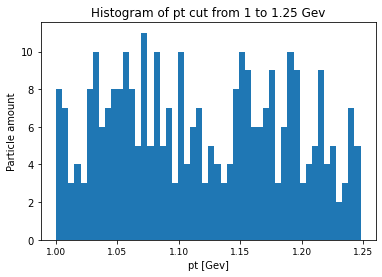

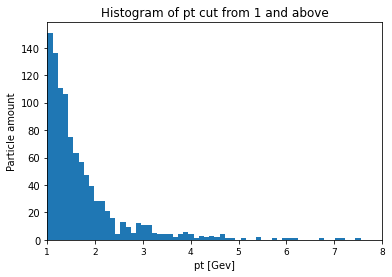

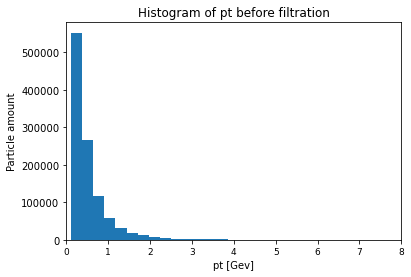

In [9]:
%%time
eqw = np.array(pt_after_filter2(hits_merge_all_filter_PtAll))
arr = eqw[eqw >= 8]
print(len(arr))
ewq = np.array(pt_pre_filter(particles_all))
rew = eqw[eqw >= 8]
print(len(rew))
plt.figure(0)
plt.tick_params(axis='x', which='major', labelsize=9)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.title("Histogram of pt cut from 1 to 1.25 Gev")
plt.xlabel("pt [Gev]")
plt.ylabel("Particle amount")
plt.hist(pt_after_filter(hits_merge_all_filter_Pt125)[0],50)
plt.figure(1)
plt.tick_params(axis='x', which='major', labelsize=9)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.title("Histogram of pt cut from 1 and above")
plt.xlabel("pt [Gev]")
plt.ylabel("Particle amount")
plt.hist(pt_after_filter(hits_merge_all_filter_PtAll)[0],500)
plt.xlim(1,8)
plt.figure(2)
plt.hist(pt_pre_filter(particles_all),800)
plt.xlim(0,8)
plt.tick_params(axis='x', which='major', labelsize=9)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.title("Histogram of pt before filtration")
plt.xlabel("pt [Gev]")
plt.ylabel("Particle amount")

In [10]:
%%time
def lenght_func(data,inteval):
    data_lenght = []
    for i in range(len(data[:inteval])):
        for j in range(len(data[0][2])):
            data_lenght.append(np.round_(data[i][2][j],6))
    data_lenght_array = np.array(data_lenght).reshape(inteval,6)
    data_lenght_avg = np.round_(sum(data_lenght_array)/len(data_lenght_array))
    return data_lenght_avg

def lenght_procent_func(data,inteval):
    data_lenght = []
    for i in range(len(data[:inteval])):
        for j in range(len(data[0][2])):
            data_lenght.append(np.round_(data[i][3][j],6))
    data_lenght_array = np.array(data_lenght).reshape(inteval,6)
    data_lenght_avg = np.round_(sum(data_lenght_array)/len(data_lenght_array),2)
    return data_lenght_avg
    
event_call_list = np.array([10,20,50,75,100])
data_lenghts_all = [lenght_func(hits_merge_all_filter_PtAll,i) for i in event_call_list]
data_lenghts_procent_all = [lenght_procent_func(hits_merge_all_filter_PtAll,i) for i in event_call_list]

data_lenghts_125 = [lenght_func(hits_merge_all_filter_Pt125,i) for i in event_call_list]
data_lenghts_procent_125 = [lenght_procent_func(hits_merge_all_filter_Pt125,i) for i in event_call_list]


Wall time: 33.9 ms


In [11]:
def particles_left(data,events_call):
    lenght_all_particles_combined = []
    for i in range(len(data)):
        lenght_all_particles_combined.append(len(data[i][1]))
    return sum(lenght_all_particles_combined)

lenght_all_nodes_combined = []
for i in range(len(hits_merge_all_filter_PtAll)):
    lenght_all_nodes_combined.append(len(hits_merge_all_filter_PtAll[i][0]))

def nodes_after_filter(data,events_call):
    lenght_all_nodes_combined = []
    for i in range(len(data)):
        lenght_all_nodes_combined.append(len(data[i][0]))
    return sum(lenght_all_nodes_combined)

particles_left_Pt_all = [particles_left(hits_merge_all_filter_PtAll[:i],event_call_list) for i in event_call_list]
particles_left_Pt_125 = [particles_left(hits_merge_all_filter_Pt125[:i],event_call_list) for i in event_call_list]


nodes_after_filter_Pt_all = [nodes_after_filter(hits_merge_all_filter_PtAll[:i],event_call_list) for i in event_call_list]
nodes_after_filter_Pt_125 = [nodes_after_filter(hits_merge_all_filter_Pt125[:i],event_call_list) for i in event_call_list]

predict_edges_Pt_all = [nodes_after_filter_Pt_all[i]-particles_left_Pt_all[i] for i in range(len(particles_left_Pt_all))]
predict_edges_Pt_125 = [nodes_after_filter_Pt_125[i]-particles_left_Pt_125[i] for i in range(len(particles_left_Pt_125))]

In [12]:
lenght_table = {"Pt [1,1.25]": ["","","","","","","","",""],
'Events used': ['Avg input hits', 'Avg hits post F1', 'Avg hits post F2',"Avg hits post F3","Avg hits post F4","Avg hits post F5","Total particle count","Total nodes count","Maximum possible true edges"],

'50': [data_lenghts_125[2][0],(data_lenghts_125[2][1],f'{data_lenghts_procent_125[2][1]}%'), (data_lenghts_125[2][2],f'{data_lenghts_procent_125[2][2]}%'), (data_lenghts_125[2][3],f'{data_lenghts_procent_125[2][3]}%'), (data_lenghts_125[2][4],f'{data_lenghts_procent_125[2][4]}%'), (data_lenghts_125[2][5],f'{data_lenghts_procent_125[2][5]}%'),particles_left_Pt_125[2],nodes_after_filter_Pt_125[2],predict_edges_Pt_125[2]],
'100':[data_lenghts_125[4][0],(data_lenghts_125[4][1],f'{data_lenghts_procent_125[4][1]}%'), (data_lenghts_125[4][2],f'{data_lenghts_procent_125[4][2]}%'), (data_lenghts_125[4][3],f'{data_lenghts_procent_125[4][3]}%'), (data_lenghts_125[4][4],f'{data_lenghts_procent_125[4][4]}%'), (data_lenghts_125[4][5],f'{data_lenghts_procent_125[4][5]}%'),particles_left_Pt_125[4],nodes_after_filter_Pt_125[4],predict_edges_Pt_125[4]]
}
lenght_table = pd.DataFrame(data=lenght_table)
display(lenght_table)

lenght_table = {"Pt [1,$\infty$]": ["","","",""],
'Events used': ["Avg hits after filter 5","Total particle count","Total nodes count","Maximum possible true edges"],
'50': [ (data_lenghts_all[2][5],f"{data_lenghts_procent_all[2][5]}%"),particles_left_Pt_all[2],nodes_after_filter_Pt_all[2],predict_edges_Pt_all[2]],
'100':[ (data_lenghts_all[4][5],f"{data_lenghts_procent_all[4][5]}%"),particles_left_Pt_all[4],nodes_after_filter_Pt_all[4],predict_edges_Pt_all[4]]
}
lenght_table = pd.DataFrame(data=lenght_table)
display(lenght_table)

,"Pt [1,1.25]",Events used,50,100
0,,Avg input hits,111104.0,109675.0
1,,Avg hits post F1,"(60401.0, 54.39%)","(59670.0, 54.44%)"
2,,Avg hits post F2,"(47387.0, 42.57%)","(46656.0, 42.46%)"
3,,Avg hits post F3,"(46079.0, 41.39%)","(45377.0, 41.29%)"
4,,Avg hits post F4,"(33752.0, 30.32%)","(33253.0, 30.26%)"
5,,Avg hits post F5,"(1809.0, 1.62%)","(1775.0, 1.61%)"
6,,Total particle count,16052,31473
7,,Total nodes count,90428,177519
8,,Maximum possible true edges,74376,146046


,"Pt [1,$\infty$]",Events used,50,100
0,,Avg hits after filter 5,"(5202.0, 4.67%)","(5105.0, 4.64%)"
1,,Total particle count,45162,88488
2,,Total nodes count,260114,510504
3,,Maximum possible true edges,214952,422016


## Function that findes the edges and nodes

In [13]:
def nodes_and_edges(data,x,y,z,dpdr_filter,z0_filter):
    def transform_and_merge(data,x,y,z):
        def car_to_cyl_cood(x,y,z):
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y,x)
            z = z
            return r , phi , z 
        r_hits , phi_hits , z_hits = car_to_cyl_cood(x,y,z)
        data["phi"] = phi_hits
        data["r"] = r_hits
        return data , r_hits , phi_hits , z_hits

    hits_merge , r_hits , phi_hits , z_hits = transform_and_merge(data,data.x , data.y , data.z)
    def car_to_sphe_cood(r,z):
        theta = np.arctan2(r,z)
        return theta

    theta = car_to_sphe_cood(r_hits,z_hits)
    eta = -np.log(np.tan(theta/2))
    rr = np.array(hits_merge.r)
    zz = np.array(hits_merge.z)
    pp = np.array(hits_merge.phi)
    dpp = []
    node_to_node_feat = []
    for i, idx in enumerate(range(len(pp))):
        for k, kdx in enumerate(range(len(rr))):
            dpdr = (pp[k]- pp[i])/(rr[k]-rr[i])
            dr = rr[k]-rr[i]
            z0 =  zz[i] - (rr[i]*(zz[k]-zz[i])/(rr[k]-rr[i]))
            if abs(dpdr) < dpdr_filter and abs(z0) < z0_filter and dr > 0:
                dpp.append([(hits_merge.particle_id[i] == hits_merge.particle_id[k])*1,dpdr, idx, kdx, hits_merge.hit_id[idx],
                            hits_merge.hit_id[kdx],abs(dr),hits_merge.z[idx],hits_merge.z[kdx],hits_merge.r[idx],hits_merge.r[kdx],hits_merge.phi[idx],
                            hits_merge.phi[kdx],hits_merge.x[idx],hits_merge.x[kdx],hits_merge.y[idx],hits_merge.y[kdx]])
                node_to_node_feat.append([hits_merge.z[idx],hits_merge.z[kdx],hits_merge.r[idx],hits_merge.r[kdx],hits_merge.phi[idx],hits_merge.phi[kdx]])
    dp_over_dr_TF = pd.DataFrame(dpp)
    dp_over_dr_TF.columns = ['Y_k' , "dpdr" , 'node_1', 'node_2',"hit_id_node1","hit_id_node2","dr","z_node1","z_node2","r_node1","r_node2","phi_node1","phi_node2",
                            "x_node1","x_node2","y_node1","y_node2"]
    dp_over_dr_True = []
    for i in range(len(dpp)):
        if dpp[i][0] == 1:
            dp_over_dr_True.append(dpp[i])
    dp_over_dr_True = pd.DataFrame(dp_over_dr_True)
    dp_over_dr_True.columns = ['Y_k' , "dpdr" , 'node_1', 'node_2',"hit_id_node1","hit_id_node2","dr","z_node1","z_node2","r_node1","r_node2","phi_node1","phi_node2",
                            "x_node1","x_node2","y_node1","y_node2"]
    dp_over_dr_True = dp_over_dr_True.drop_duplicates(subset = "dpdr",ignore_index = True)
    dp_over_dr_False = []
    for i in range(len(dpp)):
        if dpp[i][0] == 0:
            dp_over_dr_False.append(dpp[i])
    dp_over_dr_False = pd.DataFrame(dp_over_dr_False)
    dp_over_dr_False.columns = ['Y_k' , "dpdr" , 'node_1', 'node_2',"hit_id_node1","hit_id_node2","dr","z_node1","z_node2","r_node1","r_node2","phi_node1","phi_node2",
                            "x_node1","x_node2","y_node1","y_node2"]
    dp_over_dr_False = dp_over_dr_False.drop_duplicates(subset = "dpdr",ignore_index = True)
    #Making the datafram that contains the nodes ids and the nodes features. 
    nodes_id_plus_features = hits_merge[["hit_id","z","r","phi"]].copy()
    return nodes_id_plus_features , dp_over_dr_True , dp_over_dr_False

In [14]:
def lenght_func(data,inteval):
    data_lenght = []
    for i in range(len(data[:inteval])):
        for j in range(len(data[0][2])):
            data_lenght.append(np.round_(data[i][2][j],6))
    data_lenght_array = np.array(data_lenght).reshape(inteval,6)
    data_lenght_avg = np.round_(sum(data_lenght_array)/len(data_lenght_array))
    return data_lenght_avg

def lenght_procent_func(data,inteval):
    data_lenght = []
    for i in range(len(data[:inteval])):
        for j in range(len(data[0][2])):
            data_lenght.append(np.round_(data[i][3][j],6))
    data_lenght_array = np.array(data_lenght).reshape(inteval,6)
    data_lenght_avg = np.round_(sum(data_lenght_array)/len(data_lenght_array),2)
    return data_lenght_avg
    
event_call_list = np.array([10,20,50,75,100])

data_lenghts_125 = [lenght_func(hits_merge_all_filter_Pt125,i) for i in event_call_list]
data_lenghts_procent_125 = [lenght_procent_func(hits_merge_all_filter_Pt125,i) for i in event_call_list]
particles_left_Pt_125_5 = particles_left(hits_merge_all_filter_Pt125[:5],event_call_list)
nodes_after_filter_Pt_125_5 = nodes_after_filter(hits_merge_all_filter_Pt125[:5],event_call_list)
predict_edges_Pt_125_5 = nodes_after_filter_Pt_125_5-particles_left_Pt_125_5

In [15]:
%%time
def nodes_edges_dpdr_tester(data,events,dpdr_filter,z0_filter):
    hits_merge_all = [nodes_and_edges(data[i][0] , data[i][0].x , data[i][0].y , data[i][0].z,dpdr_filter,z0_filter) for i in range(events)] 
    All_edges_T = [REWMHT(hits_merge_all[i]) for i in range(len(hits_merge_all))] 
    All_edges_T_combined = pd.concat(All_edges_T, ignore_index=True)
    particles_left_Pt_125_5 = particles_left(data[:events],events)
    nodes_after_filter_Pt_125_5 = nodes_after_filter(data[:events],events)
    predict_edges_Pt_125_5 = nodes_after_filter_Pt_125_5-particles_left_Pt_125_5
    procent_predicted_right = len(All_edges_T_combined)/predict_edges_Pt_125_5*100
    return procent_predicted_right

Wall time: 0 ns
